In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Temporal Difference

In [21]:
def td_learning(data, alpha, gamma):
    N_s = np.zeros(5)  # Counter for the number of times state s is visited
    V = np.zeros(5)  # Assuming there are 5 states
    V_history = []

    for t, row in data.iterrows():
        s, a, r, s_next = row
        s, s_next, a = int(s), int(s_next), int(a) # Ensure we have integers where needed
        N_s[s] += 1  # Increment state visit count
        
        # Update rule for TD
        V[s] += alpha(t, s, N_s) * (r + gamma * V[s_next] - V[s])
        V_history.append(V.copy())

    return V, V_history

# Model Based Policy Evaluation

In [22]:
def mb_pe(data, gamma, alpha):
    num_states = 5
    # Initialize model
    N_s = np.zeros(num_states)    
    N_ss = np.zeros((num_states, num_states))
    V = np.zeros(num_states) 
    V_history = []
    rewards = np.zeros(num_states)  
    
    # Initialize model
    P_hat = np.zeros((num_states, num_states))
    r_hat = np.zeros(num_states)  

    # First, learn the model
    for t, row in data.iterrows():
        s, a, r, s_next = row
        s, s_next, a = int(s), int(s_next), int(a) # Ensure we have integers where needed
        
        # Update model
        N_s[s] += 1
        N_ss[s, s_next] += 1
        
        rewards[s] += r
        
        # Calculate smoothed estimates for transition probabilities and rewards
        P_hat = (N_ss + alpha) / (N_s + alpha * num_states)
        r_hat = (rewards + alpha) / (N_s + alpha)
        V = np.linalg.inv(np.eye(num_states) - gamma * P_hat) @ r_hat
        V_history.append(V.copy())      

    return V, V_history

## Utils

In [23]:
def learning_rate_1(t, *args):
    return 10/(t**(2/3)+1)

def learning_rate_2(t, s, N_s):
    return 10/(N_s[s]**(7/9)+1)

def p1(num_states):
    """ Always go right until the final state and stay there"""
    P = np.full((num_states, 2), (0, 1))
    
    return P

def p2(num_states):
    """ Go right/left with 50% probability """
    pi = np.full((num_states, 2), 0.5)
        
    return pi

# Experiments

In [24]:
import numpy as np

class Riverswim:
    """
    Sourced from Absalon and rewritten by bkx591
    """
    def __init__(self, states_count, actions_count=2, gamma=0.95, R=None):
        self.states_count = states_count
        self.actions_count = actions_count
        self.P = np.zeros((states_count, actions_count, states_count))
        self.R = np.zeros((states_count, actions_count))
        self.gamma = gamma  # Discount factor

        for s in range(states_count):
            if s == 0:
                self.P[s, 0, s] = 1
                self.P[s, 1, s] = 0.6
                self.P[s, 1, s + 1] = 0.4
                self.R[s, 0] = 0.05
            elif s == states_count - 1:
                self.P[s, 0, s - 1] = 1
                self.P[s, 1, s] = 0.6
                self.P[s, 1, s - 1] = 0.4
                self.R[s, 1] = 1 
            else:
                self.P[s, 0, s - 1] = 1
                self.P[s, 1, s] = 0.55
                self.P[s, 1, s + 1] = 0.4
                self.P[s, 1, s - 1] = 0.05

        self.s = 0

    def reset(self, s=0):
        self.s = s
        return self.s

    def step(self, action):
        new_s = np.random.choice(np.arange(self.states_count), p=self.P[self.s, action])
        reward = self.R[self.s, action]
        self.s = new_s
        return new_s, reward

    def policy_matrix(self, policy):
        # Create a policy matrix that represents the transition probabilities under the given policy.
        policy_mat = np.zeros((self.states_count, self.states_count))
        for s in range(self.states_count):
            policy_prob = policy[s]
            # Calculate the expected transition probability for each state under the given policy
            policy_mat[s] = policy_prob[0] * self.P[s, 0] + policy_prob[1] * self.P[s, 1]
        return policy_mat

    def reward_vector(self, policy):
        # Create a reward vector that represents the expected immediate reward from each state under the given policy.
        reward_vec = np.zeros(self.states_count)
        for s in range(self.states_count):
            policy_prob = policy[s]
            # Calculate the expected immediate reward for each state under the given policy
            reward_vec[s] = policy_prob[0] * self.R[s, 0] + policy_prob[1] * self.R[s, 1]
        return reward_vec

In [25]:
# Load the data from CSV files
data_p1 = pd.read_csv('data_policy1.csv')
data_p2 = pd.read_csv('data_policy2.csv')

gamma = 0.95  # Discount factor
env = Riverswim(5) # Reuse the environment from the previous task

# True policies from our environment
V_true_pi1 = np.linalg.inv(np.eye(5) - gamma * env.policy_matrix(p1(5))) @ env.reward_vector(policy=p1(5))

V_true_pi2 =  np.linalg.inv(np.eye(5) - gamma * env.policy_matrix(p2(5))) @ env.reward_vector(policy=p2(5))

# Run TD learning for both policies and both learning rates
V_td_pi1_a1, V_td_history_pi1_a1 = td_learning(data_p1, learning_rate_1, gamma)
V_td_pi1_a2, V_td_history_pi1_a2 = td_learning(data_p1, learning_rate_2, gamma)
V_td_pi2_a1, V_td_history_pi2_a1 = td_learning(data_p2, learning_rate_1, gamma)
V_td_pi2_a2, V_td_history_pi2_a2 = td_learning(data_p2, learning_rate_2, gamma)

# Run MB-PE for both policies
V_mb_pi2, V_mb_history_pi2 = mb_pe(data_p2, gamma, 1/5)
V_mb_pi1, V_mb_history_pi1 = mb_pe(data_p1, gamma, 1/5)

# Pretty print the true value functions
print('True value function for policy 1:', V_true_pi1)
print('True value function for policy 2:', V_true_pi2)

# Pretty print the value functions
print('Value function for policy 1 (TD, learning rate 1):', V_td_pi1_a1)
print('Value function for policy 1 (TD, learning rate 2):', V_td_pi1_a2)
print('Value function for policy 1 (MB-PE):', V_mb_pi1)
print('Value function for policy 2 (TD, learning rate 1):', V_td_pi2_a1)
print('Value function for policy 2 (TD, learning rate 2):', V_td_pi2_a2)
print('Value function for policy 2 (MB-PE):', V_mb_pi2)

True value function for policy 1: [ 5.9207526   6.69979899  7.67873229  8.81145847 10.11245167]
True value function for policy 2: [0.40230971 0.37660174 0.40822404 0.59865995 1.25609632]
Value function for policy 1 (TD, learning rate 1): [0.87373969 5.2337101  7.25414914 8.49279742 9.81063454]
Value function for policy 1 (TD, learning rate 2): [6.08838884 6.68248259 7.51489046 8.63342051 9.94743705]
Value function for policy 1 (MB-PE): [ 0.03250104  0.13127899  1.01574111  8.87438054 10.11309841]
Value function for policy 2 (TD, learning rate 1): [0.40905422 0.38215166 0.41920948 0.58122341 1.33686601]
Value function for policy 2 (TD, learning rate 2): [0.40061578 0.36569495 0.38061556 0.47067927 1.36853576]
Value function for policy 2 (MB-PE): [4.78002442 2.2901927  1.61649905 1.46717365 1.1853271 ]


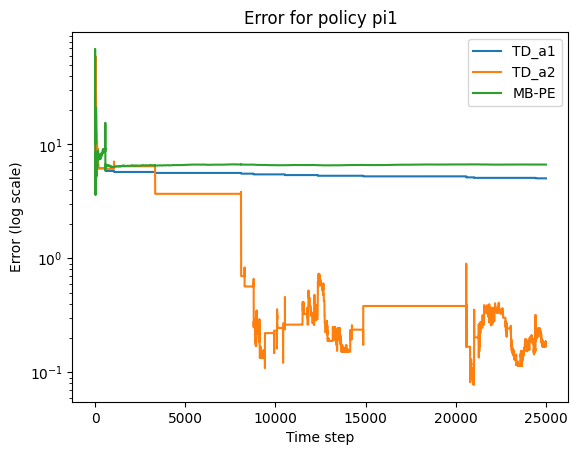

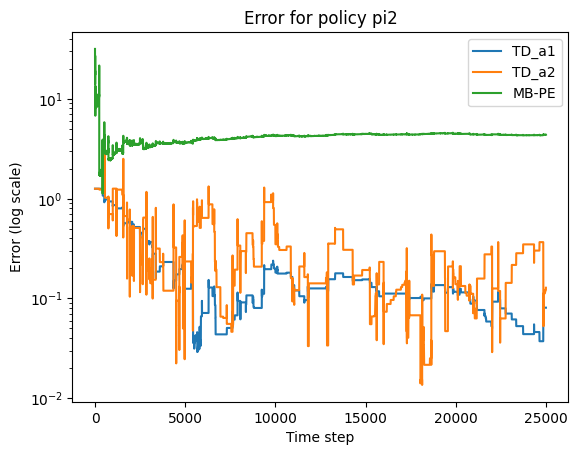

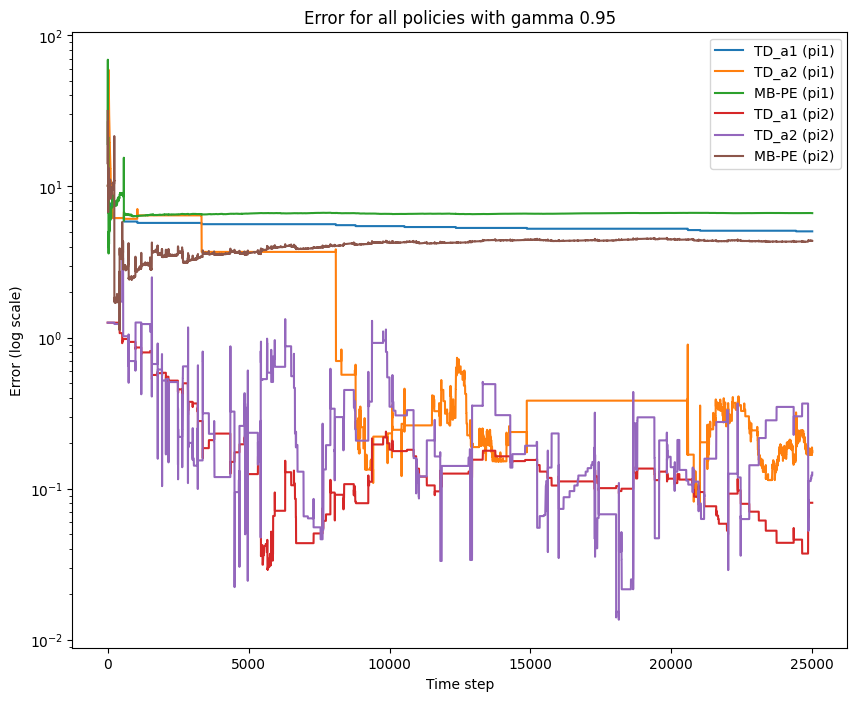

In [37]:

def plot_errors(V_history, V_true, policies, methods, gamma):
    errors = {policy: {method: [] for method in methods} for policy in policies}
    
    for policy in policies:
        for method in methods:
            for V_estimated in V_history[policy][method]:
                error = np.max(np.abs(V_estimated - V_true[policy]))
                errors[policy][method].append(error)
    
    for policy in policies:
        plt.figure()
        for method in methods:
            plt.plot(errors[policy][method], label=method)
        
        plt.yscale('log')
        plt.title(f'Error for policy {policy}')
        plt.xlabel('Time step')
        plt.ylabel('Error (log scale)')
        plt.legend()
        plt.savefig(f'artifacts/errors_{policy}_gamma_{gamma}.png', dpi=300)
        plt.show()
        
def plot_errors_single(V_history, V_true, policies, methods, gamma):
    errors = {policy: {method: [] for method in methods} for policy in policies}
    
    # Calculate the errors
    for policy, methods_values in V_history.items():
        for method, V_estimated_history in methods_values.items():
            for V_estimated in V_estimated_history:
                error = np.max(np.abs(V_estimated - V_true[policy]))
                errors[policy][method].append(error)
    
    # Plot all errors on one plot
    plt.figure(figsize=(10, 8))
    for policy in policies:
        for method in methods:
            plt.plot(errors[policy][method], label=f'{method} ({policy})')
    
    plt.yscale('log')
    plt.title(f'Error for all policies with gamma {gamma}')
    plt.xlabel('Time step')
    plt.ylabel('Error (log scale)')
    plt.legend()
    plt.savefig(f'artifacts/errors_all_policies_gamma_{gamma}.png', dpi=300)
    plt.show()

# Plot the errors
V_history = {
    'pi1': {'TD_a1': V_td_history_pi1_a1, 'TD_a2': V_td_history_pi1_a2, 'MB-PE': V_mb_history_pi1},
    'pi2': {'TD_a1': V_td_history_pi2_a1, 'TD_a2': V_td_history_pi2_a2, 'MB-PE': V_mb_history_pi2}
}
V_true = {
    'pi1': V_true_pi1,
    'pi2': V_true_pi2
}
plot_errors(V_history, V_true, ['pi1', 'pi2'], ['TD_a1', 'TD_a2', 'MB-PE'], 0.95)
plot_errors_single(V_history, V_true, ['pi1', 'pi2'], ['TD_a1', 'TD_a2', 'MB-PE'], 0.95)